# Summary

Explore derivation of indicatrix and figuratrix. 

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    # pr_filenames = ['IndicatrixExploration_sinbeta_eta1p5']
    pr_filenames = ['IndicatrixExploration_sinbeta_eta0p5']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Logging

In [2]:
from importlib import reload
import logging, sys
reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s')

### Modules

In [3]:
# Import Numpy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
from sympy import Matrix, Eq, lambdify, poly, \
    simplify, factor, expand, cancel, collect, expand_trig, \
    sin,cos,tan,sec, atan, Rational, sqrt, solve, Abs, N, re, im, \
    diff, pi, numer, denom,init_printing
# Set up latex inline printing
init_printing(pretty_print=True,wrap_line=True)

# Import units & dimensions
from sympy.physics.units import degrees
from sympy.physics.units.systems import SI

# Pretty dict printing etc
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
from datetime import datetime

# Scipy utils
from scipy.optimize import root_scalar
from scipy.linalg import norm

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.core.symbols import *
from gme.core.equations import Equations
from gme.plot.indicatrix_new import IndicatrixNew

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme)
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['IndicatrixExploration_sinbeta_eta0p5'])

### Parameter parsing

In [4]:
parameters_dict,_ = import_parameters(pr_path, [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/defaults.json
gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/Theory/IndicatrixExploration_sinbeta_eta0p5.json
gmplib.parameters.ParametersNestedGroup: p.job
gmplib.parameters.ParametersNestedGroup: p.model
gmplib.parameters.ParametersNestedGroup: p.solve
gmplib.parameters.ParametersNestedGroup: p.resolve
gmplib.parameters.ParametersNestedGroup: p.plot
gmplib.parameters.ParametersNestedGroup: p.save


{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'indicatrix_exploration',
    'subtitle': '',
    'title': 'Exploration of indicatrix etc for sin(beta) erosion model, '
             'eta=1/2',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    't_xiv0_list': None,
    'varepsilon': 1/1000,
    'varepsilonhat': 1/100,
    'varphi_0': 300,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
 

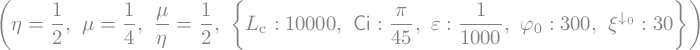

In [5]:
subexp = {
    eta: pr.model.eta,
    mu: pr.model.mu
}
sub = {
        Ci: pr.model.Ci, 
        Lc: pr.model.Lc, 
        varepsilon: pr.model.varepsilon, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
#         kappa_h: pr.model.kappa_h,
#         h_0: pr.model.h_0,
#         x_sigma: pr.model.x_sigma,
#         x_h: pr.model.x_h
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Theory

In [6]:
gmeq = Equations( eta_=pr.model.eta, 
                  mu_=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
#                   ibc_type=pr.model.ibc_type,
                  parameters=sub, 
                  do_raw=False )

gme.core.equations.Equations
gme.core.equations.EquationsMixedIn
gme.core.equations.EquationsBase
gme.core.rp.define_p_eqns
gme.core.rp.define_r_eqns
gme.core.xi.define_xi_eqns
gme.core.xi.define_xi_model_eqn
gme.core.xi.define_xi_related_eqns
gme.core.varphi.define_varphi_model_eqns
gme.core.varphi.define_varphi_related_eqns
gme.core.fundamental.define_Fstar_eqns
gme.core.fundamental.define_H_eqns
gme.core.hamiltons.define_rdot_eqns
gme.core.hamiltons.define_pdot_eqns
gme.core.hamiltons.define_Hamiltons_eqns
gme.core.ndim.nondimensionalize
gme.core.ndim.define_nodimensionalized_Hamiltons_eqns
gme.core.profile.define_z_eqns
gme.core.angles.define_tanalpha_eqns
gme.core.angles.define_tanbeta_eqns
gme.core.angles.define_psi_eqns
gme.core.metrictensor.define_g_eqns
gme.core.pxpoly.define_px_poly_eqn (ndim=False)
gme.core.pxpoly.define_px_poly_eqn (ndim=True)


In [7]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta'])
# prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_eta{float(N(gmeq.eta_))}'
# suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.2f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
#                                     else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
# suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix.replace('.','p')
job_name

'indicatrix_exploration_sinbeta_eta0p5'

# Plots

In [8]:
gr = IndicatrixNew(gmeq, pr, subexp, varphi_=1)

In [9]:
import sympy as sy
s = sy.symbols(r's',  real=True)
vx = sy.symbols(r'x',  real=True)
vz = sy.symbols(r'z',  real=True)
v = sy.symbols(r'v',  real=True, positive=True)

Grab closed-form Lagrangian for $\eta=1/2$ and $\alpha<\alpha_{\mathrm{ext}}$.

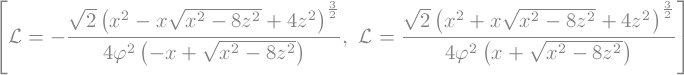

In [10]:
L_compact_eqn = Eq(L, 
    -s*(sqrt(2)*(vx**2-s*vx*sqrt(vx**2-8*vz**2)+4*vz**2)**Rational(3,2)
        /(4*varphi**2*(-s*vx+sqrt(vx**2-8*vz**2)))) 
)
L_compact_eqns = [
    L_compact_eqn.subs({s:s_}) for s_ in (+1,-1)
]
F_compact_eqns = [
    Eq(F, (sqrt(L*2)).subs(e2d(L_compact_eqn_)))
    for L_compact_eqn_ in L_compact_eqns
]
del L_compact_eqn
L_compact_eqns

In [11]:
if gmeq.eta_==Rational(1,2):
    vx_,vz_ = 0.9,-0.2978
    px_,pz_ = 0.6630963505914919,-1.354973165538337
else:
    vx_,vz_ = 1.05462010732076, 0.214847320357639
    px_,pz_ = 1.15,-1.
varphi_ = 1

In [12]:
vx_,vz_

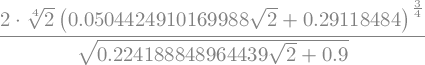

In [13]:
F_compact_eqns[1].rhs.subs({varphi:1, vx:vx_, vz:vz_})

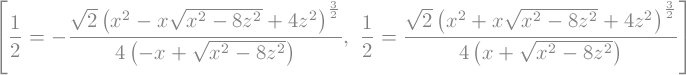

In [14]:
vx_vz_implicit_eqns = [
    L_compact_eqn_.subs({L:Rational(1,2), varphi:1})
    for L_compact_eqn_ in L_compact_eqns
]
vx_vz_implicit_eqns

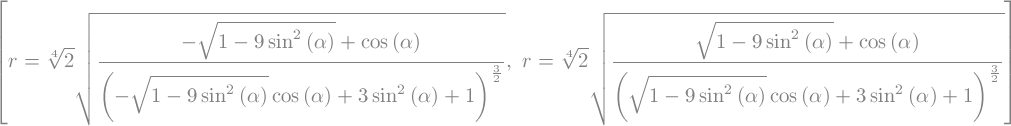

In [15]:
r_sinalpha_eqns = [
        Eq( r,
        s_*solve((sy.trigsimp(vx_vz_implicit_eqn_.subs({vx:v*cos(alpha),vz:-v*sin(alpha)}))
        .subs({cos(alpha)**2:1-sin(alpha)**2})), v)[0]
    )
    for (vx_vz_implicit_eqn_,s_) in zip(vx_vz_implicit_eqns, (+1,-1))
]
r_sinalpha_eqns

In [16]:
[
    ( r_sinalpha_eqn_.rhs.subs({alpha:sy.rad(0.1)}).n() )
    for r_sinalpha_eqn_ in r_sinalpha_eqns
]

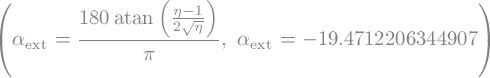

In [17]:
alpha_ext_eqn = Eq( alpha_ext, sy.deg(atan( (eta-1)/(2*sqrt(eta))) ) )
alpha_ext_eqn, alpha_ext_eqn.subs({eta:gmeq.eta_}).n()

In [18]:
r_sinalpha_lambdifieds = [
    lambdify((alpha), r_sinalpha_eqn_)
    for r_sinalpha_eqn_ in r_sinalpha_eqns
]
r_sinalpha_lambdas = [
    lambda alpha_: r_sinalpha_lambdified_(alpha_)
    for r_sinalpha_lambdified_ in r_sinalpha_lambdifieds
]

In [30]:
# vx_vz_flat_eqns = [
#     Eq(
#         (vx_vz_implicit_eqn_.lhs*sy.denom(vx_vz_implicit_eqn_.rhs))**2,
#         (sy.numer(vx_vz_implicit_eqn_.rhs))**2
#     )
#     for vx_vz_implicit_eqn_ in vx_vz_implicit_eqns
# ]
# vx_vz_flat_eqns

In [20]:
# vx_vz_flat_eqn_ = expand(vx_vz_flat_eqns[0])
# _ = Eq(
#     (vx ** 2 - 8 * vz ** 2),
#     (solve(vx_vz_flat_eqn_.subs({sqrt(vx ** 2 - 8 * vz ** 2): y}), y)[0])**2,
# )
# simplify(Eq(_.lhs*denom(_.rhs)-numer(_.rhs),0))


gmplib.plot.GraphingBase:
   Creating plot: indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear size=(7, 9) @ 100 dpi


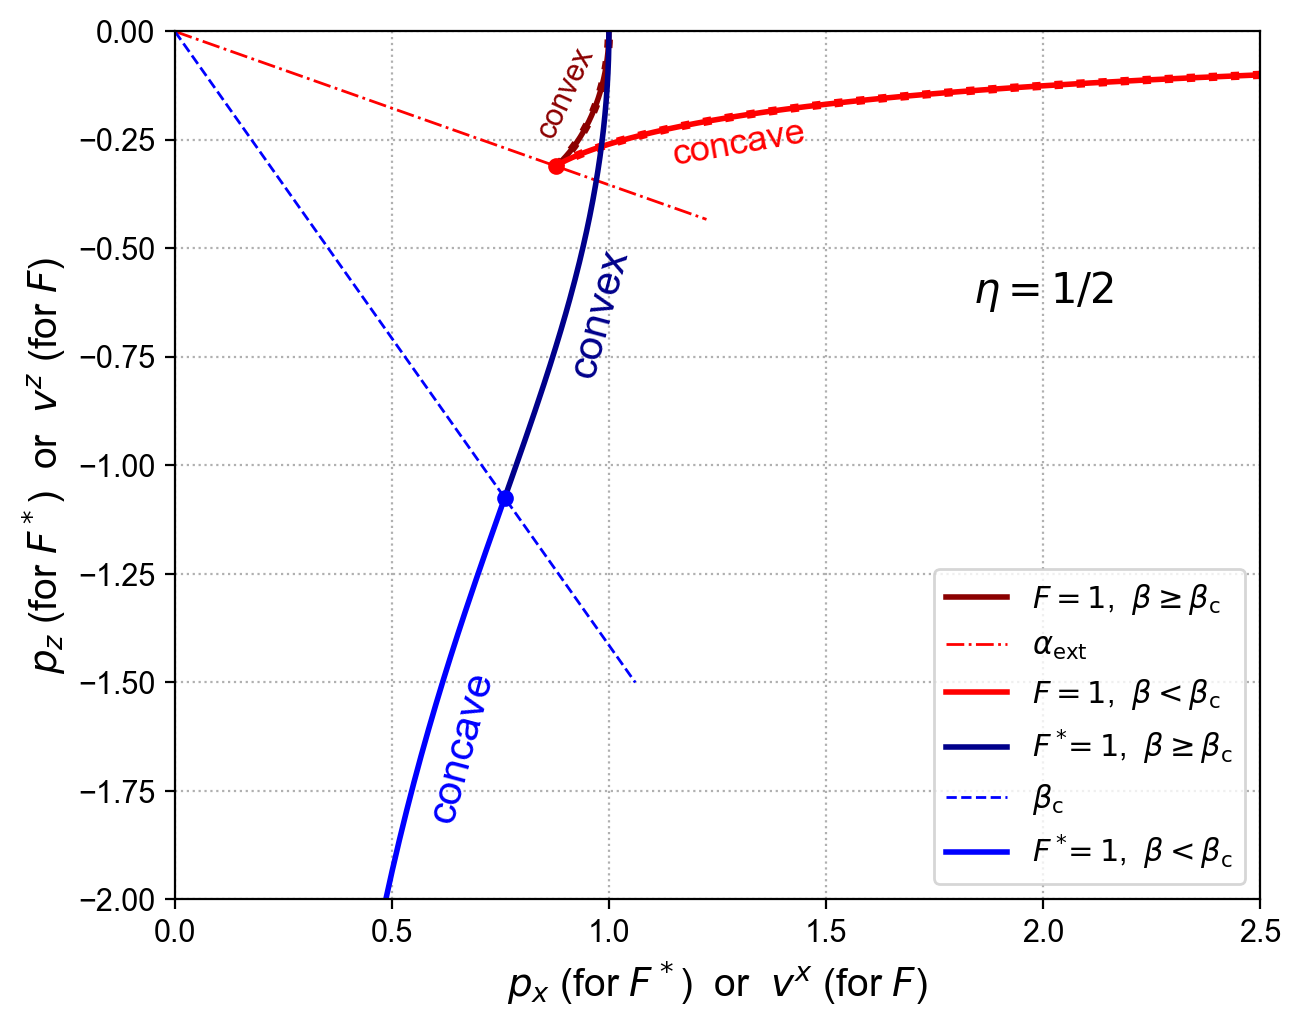

In [27]:
gr.Fstar_F_rectlinear(gmeq, job_name, pr, r_eqns=r_sinalpha_eqns, fig_size=(7,9))

gmplib.plot.GraphingBase:
   Creating plot: indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear_zoom size=(7, 7) @ 100 dpi


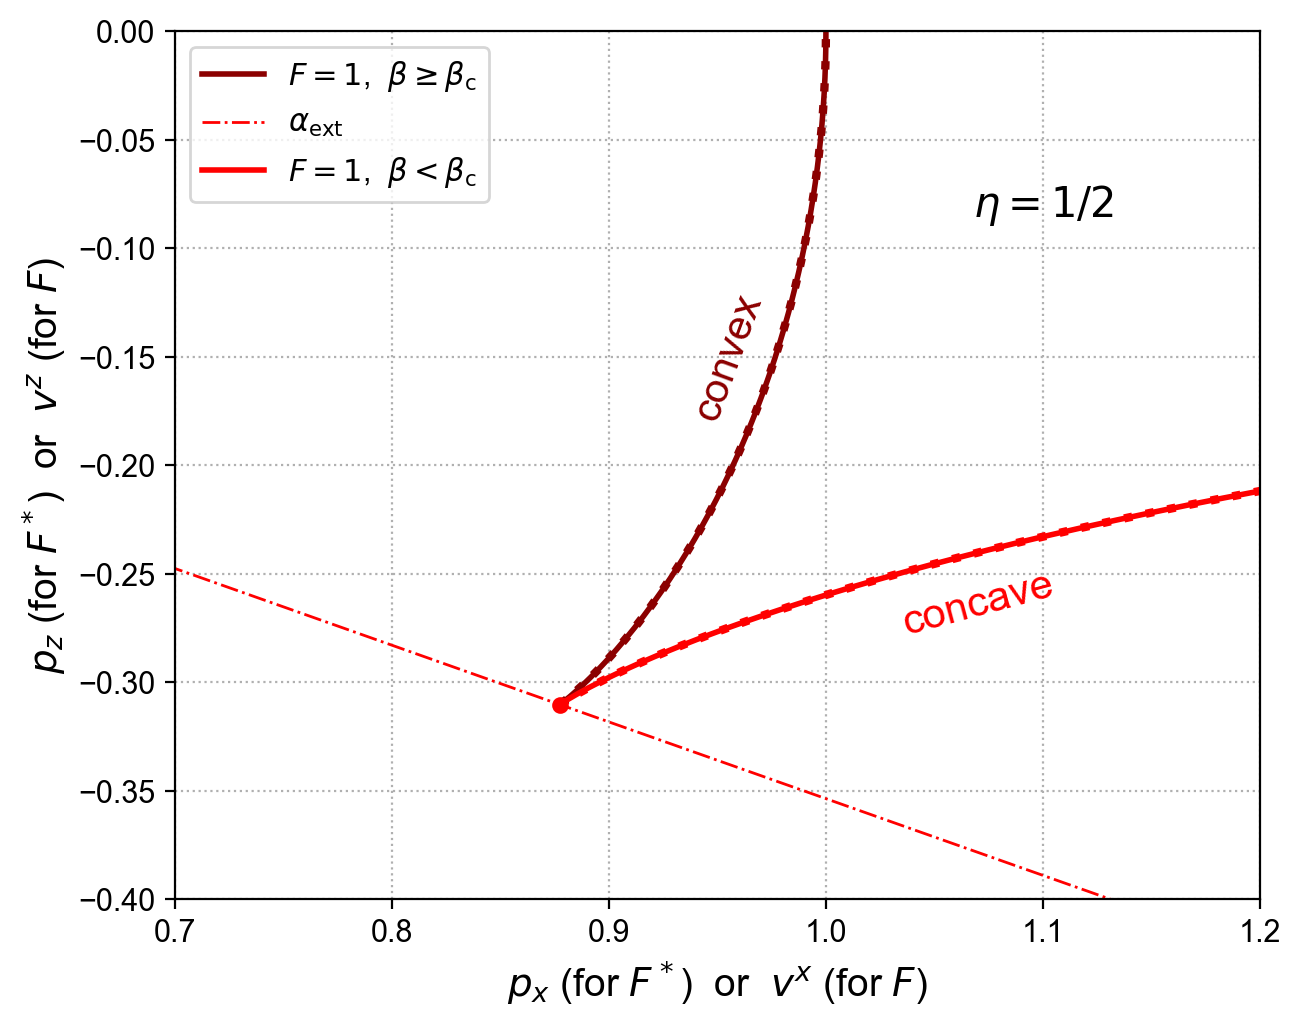

In [28]:
gr.Fstar_F_rectlinear(gmeq, job_name, pr, r_eqns=r_sinalpha_eqns, fig_size=(7,7), do_zoom=True)

gmplib.plot.GraphingBase:
   Creating plot: indicatrix_exploration_sinbeta_eta0p5_Fstar_F_polar size=[6, 6] @ 100 dpi


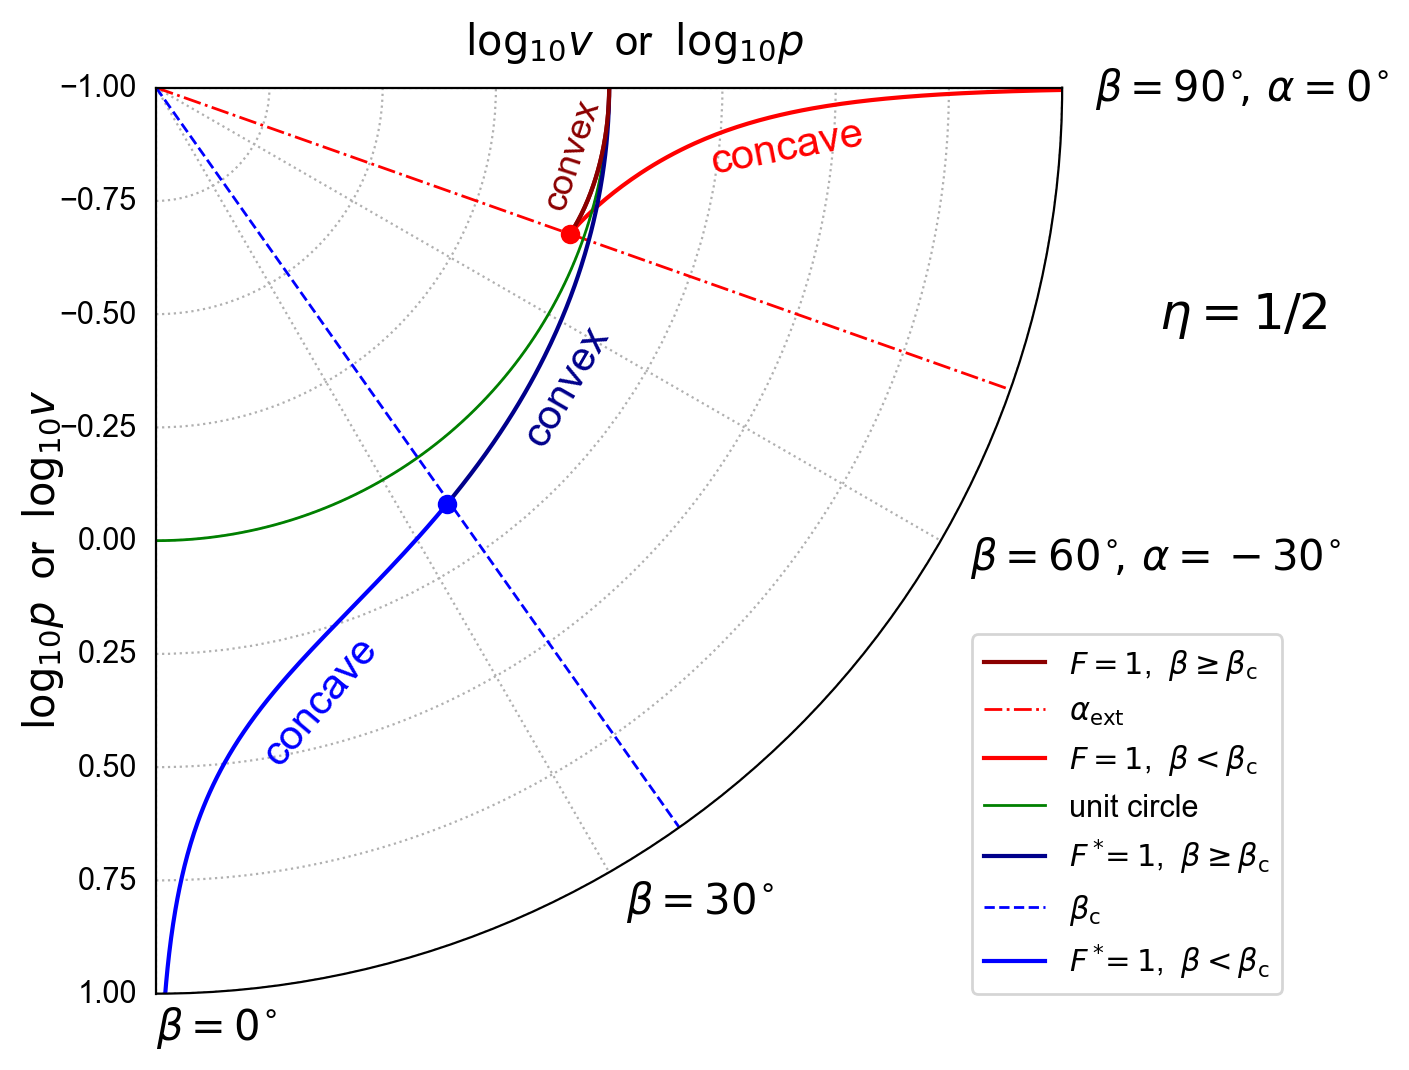

In [29]:
gr.Fstar_F_polar(gmeq, job_name, pr, fig_size=[6,6])

# Save

In [24]:
pp(gr.fdict)

{   'indicatrix_exploration_sinbeta_eta0p5_Fstar_F_polar': <Figure size 600x600 with 1 Axes>,
    'indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear': <Figure size 700x900 with 1 Axes>,
    'indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear_zoom': <Figure size 700x700 with 1 Axes>}


In [25]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

gmplib.save.export_plots:
   Writing to dir: "/Users/colinstark/Projects/GME/Plots/Theory"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear.jpg"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear_zoom.jpg"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_polar.jpg"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear.pdf"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear_zoom.pdf"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_polar.pdf"
